# Machine Learning Model

## Seismic Peligrosity Classification

Our goal is to categorize an earthquake dangerousness based in it's properties. For this, we are going to use an unsupervised model such as K-Means and DBSCAN. 


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import db_dtypes
import datetime

from google.cloud import bigquery
from google.oauth2 import service_account

import sklearn.compose
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans


from matplotlib import style
style.use ('dark_background')


In [52]:
# Import 'earthquake_deduped' data from BigQuery:

project_id = 'seismic-alert-system'

credentials = service_account.Credentials.from_service_account_file('seismic-alert-system-31876e79136b.json')
client = bigquery.Client(project=project_id, location='southamerica-east1', credentials=credentials)

#dataset = client.create_dataset('ML_test', exists_ok=True)


In [53]:
# Get the table from BigQuery
table = client.get_table("seismic-alert-system.seismic_datawarehouse.earthquake_deduped")

In [54]:
df = client.list_rows(table).to_dataframe()

In [55]:
df

,time,place,mag,magType,depth,latitude,longitude
0,2022-11-02 22:19:25.000,85 km al SE de Arica - Chile,4.00,Mb,59.050,-19.2078,-70.0687
1,2022-09-29 15:09:49.000,175 km al NE de La Serena - Chile,4.00,Mb,145.290,-28.9031,-69.859
2,2022-10-02 10:36:37.000,149 km al SE de Iquique - Chile,4.00,Mb,184.000,-21.15,-69.13
3,2022-09-30 07:35:33.000,Antofagasta - Chile,4.00,Mb,128.650,-22.6113,-68.5343
4,2022-09-19 23:55:20.000,37 km al S de Valparaíso - Chile,4.00,Mb,35.000,-33.3612,-71.7152
...,...,...,...,...,...,...,...
694,2022-11-28 13:05:27.570,"12 km NNE of Pāhala, Hawaii",1.81,ml,8.170,19.3043327331543,-155.434997558594
695,2022-11-28 10:39:08.327,"150 km NNE of Calama, Chile",4.60,mww,153.554,-21.1637,-68.4698
696,2022-11-26 06:05:35.603,"Pagan region, Northern Mariana Islands",5.60,mww,18.051,18.7113,146.9627
697,2022-11-24 09:15:25.457,"25 km SW of Malango, Solomon Islands",5.40,mww,10.000,-9.8276,159.5324


In [56]:
df.sort_values('time')

,time,place,mag,magType,depth,latitude,longitude
79,2022-09-05 07:50:58.000,75 km al SO de Valparaíso - Chile,4.90,Mb,10.00,-33.4356,-72.2752
96,2022-09-06 04:46:04.000,178 km al NE de Antofagasta - Chile,4.20,Mb,101.00,-22.71,-68.99
17,2022-09-06 13:14:36.000,160 km al NE de Antofagasta - Chile,5.00,Mb,94.24,-23.0973,-68.9547
66,2022-09-06 21:23:01.000,117 km al E de Arica - Chile,4.40,Mb,111.00,-18.57,-69.19
91,2022-09-08 23:13:47.000,154 km al NO de Concepción - Chile,4.20,Mb,10.00,-35.4987,-73.5291
...,...,...,...,...,...,...,...
324,2022-11-29 20:31:40.470,"31 km NNW of Charlotte Amalie, U.S. Virgin Isl...",2.85,md,38.61,18.5986666666667,-65.0665
309,2022-11-29 20:34:50.420,"3km ENE of Bishop, CA",2.22,md,5.90,37.375,-118.3649979
244,2022-11-29 20:35:31.080,"26 km E of Honaunau-Napoopoo, Hawaii",2.28,md,-0.84,19.4570007324219,-155.608673095703
451,2022-11-29 20:55:47.374,"54 km NNE of Chickaloon, Alaska",1.70,ml,38.20,62.262,-148.1279


In [31]:
# Drop of non important columns:

df = df.drop(['latitude', 'longitude', 'time', 'place'], axis=1)

In [32]:
df 

,mag,magType,depth
0,4.00,Mb,59.050
1,4.00,Mb,145.290
2,4.00,Mb,184.000
3,4.00,Mb,128.650
4,4.00,Mb,35.000
...,...,...,...
694,1.81,ml,8.170
695,4.60,mww,153.554
696,5.60,mww,18.051
697,5.40,mww,10.000


In [33]:
# Set a OneHotEncoder for magType column:

encoder = sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown= 'error')

encoder.fit(df[['magType']])

OneHotEncoder()

In [34]:
encoder.categories_

[array(['Mb', 'Ml', 'Mw', 'mb', 'md', 'ml', 'mww'], dtype=object)]

In [35]:
column_transf = make_column_transformer((encoder, ['magType']), remainder= 'passthrough')

In [36]:
df = column_transf.fit_transform(df)

In [37]:
df

array([[  1.   ,   0.   ,   0.   , ...,   0.   ,   4.   ,  59.05 ],
       [  1.   ,   0.   ,   0.   , ...,   0.   ,   4.   , 145.29 ],
       [  1.   ,   0.   ,   0.   , ...,   0.   ,   4.   , 184.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   5.6  ,  18.051],
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   5.4  ,  10.   ],
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   5.4  ,  43.61 ]])

In [38]:
# Import ML model K-means and trains with df
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 4, random_state= 12)

In [39]:
kmeans.fit(df)

KMeans(n_clusters=4, random_state=12)

In [41]:
rad= kmeans.labels_
center = kmeans.cluster_centers_

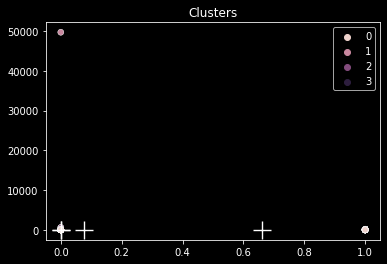

In [47]:
# Plot:

sns.scatterplot(x = df[:, 0], y = df[:, -1], hue = rad)
sns.scatterplot(x = center[:, 0], y = center[:, 1],color='white', marker="+", s=300)
plt.title('Clusters')
plt.show()

In [ ]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2022-09-25&endtime=2022-11-01'
json_obj = urlopen(url)
data = json.load(json_obj)
df = pd.json_normalize(data, record_path=['features'])

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=12)

kmeans.fit(db)
